# Pré-traitement et Entraînement des Modèles

In [39]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Ajouter le chemin vers le module DatasetLoader
current_dir = Path().resolve()
ml_models_dir = current_dir.parent
scoring_dir = ml_models_dir.parent
sys.path.insert(0, str(scoring_dir))

from ml_models.dataset_loader import DatasetLoader

print("Imports réussis")


Imports réussis


## 1. Chargement des Données


In [40]:
# Chargement du dataset
DATA_DIR = Path("../datasets")
DATA_DIR.mkdir(parents=True, exist_ok=True)

DATASET_PATH = DATA_DIR / "dataset_scoring.csv"
print(f"Chargement du dataset : {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)
print(f"Dataset: {len(df)} échantillons, {len(df.columns)} colonnes")
df.head()

Chargement du dataset : ..\datasets\dataset_scoring.csv
Dataset: 10000 échantillons, 12 colonnes


,co2_kg,water_l,energy_mj,packaging_plastic,packaging_glass,packaging_paper,packaging_other,data_completeness,ingredient_count,transport_distance_km,target_score,target_grade
0,1.178888,71.593908,15.027165,0,0,1,0,0.685504,18,190.143536,33.649452,D
1,0.413791,31.519062,5.073382,0,0,1,0,0.358643,11,2615.233725,76.771549,B
2,0.520213,32.330222,10.836873,0,1,0,0,0.672480,16,93.451368,69.214755,B
3,1.803292,83.343048,18.857257,0,0,0,1,0.760908,15,1108.969567,0.000000,E
4,0.700231,45.170204,9.795057,0,1,0,0,0.827470,10,1178.418475,54.759691,C


## 2. Exploration des Données

### Types de données et statistiques de base


In [41]:
# Types de données
print("Types de données:")
print(df.dtypes)
print()

# Statistiques descriptives pour toutes les colonnes numériques
print("Statistiques descriptives (toutes les colonnes numériques):")
print(df.describe())
print()

# Info sur le dataframe
print("Informations sur le DataFrame:")
df.info()


Types de données:
co2_kg                   float64
water_l                  float64
energy_mj                float64
packaging_plastic          int64
packaging_glass            int64
packaging_paper            int64
packaging_other            int64
data_completeness        float64
ingredient_count           int64
transport_distance_km    float64
target_score             float64
target_grade              object
dtype: object

Statistiques descriptives (toutes les colonnes numériques):
             co2_kg       water_l     energy_mj  packaging_plastic  \
count  10000.000000  10000.000000  10000.000000       10000.000000   
mean       0.858137     52.414214     10.786661           0.085100   
std        0.545632     27.560768      5.489479           0.279044   
min        0.050002      5.000578      1.000169           0.000000   
25%        0.355670     28.741263      6.044061           0.000000   
50%        0.794035     52.590107     10.851528           0.000000   
75%        1.275913  

### Vérification des valeurs manquantes et doublons


In [42]:
# Comptage des valeurs manquantes par colonne
valeurs_manquantes = df.isnull().sum()
print("Valeurs manquantes par colonne:")
print(valeurs_manquantes)
print()

if valeurs_manquantes.sum() > 0:
    print(f"⚠️ Total de valeurs manquantes: {valeurs_manquantes.sum()}")
    # Supprimer les lignes avec des valeurs manquantes
    df = df.dropna()
    print("Lignes avec valeurs manquantes supprimées")
else:
    print("Aucune valeur manquante")

# Vérifier s'il y a des doublons
nb_doublons = df.duplicated().sum()
print(f"\nNombre de lignes en double: {nb_doublons}")

if nb_doublons > 0:
    print("Lignes en double:")
    print(df[df.duplicated()].head())
else:
    print("Aucun doublon trouvé")


Valeurs manquantes par colonne:
co2_kg                   0
water_l                  0
energy_mj                0
packaging_plastic        0
packaging_glass          0
packaging_paper          0
packaging_other          0
data_completeness        0
ingredient_count         0
transport_distance_km    0
target_score             0
target_grade             0
dtype: int64

Aucune valeur manquante

Nombre de lignes en double: 0
Aucun doublon trouvé


### Visualisation des distributions


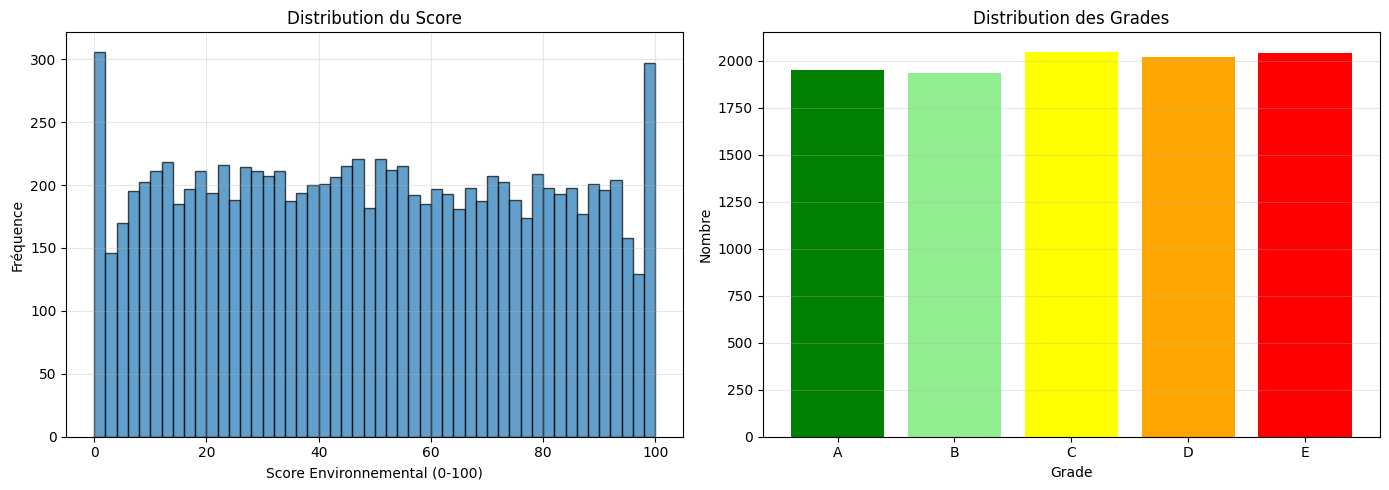

In [43]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme du score
axes[0].hist(df['target_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Score Environnemental (0-100)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution du Score')
axes[0].grid(True, alpha=0.3)

# Distribution des grades
grade_counts = df['target_grade'].value_counts().sort_index()
axes[1].bar(grade_counts.index, grade_counts.values, color=['green', 'lightgreen', 'yellow', 'orange', 'red'])
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Nombre')
axes[1].set_title('Distribution des Grades')
axes[1].grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()


### Analyse des corrélations (Pairplot et Matrice de corrélation)


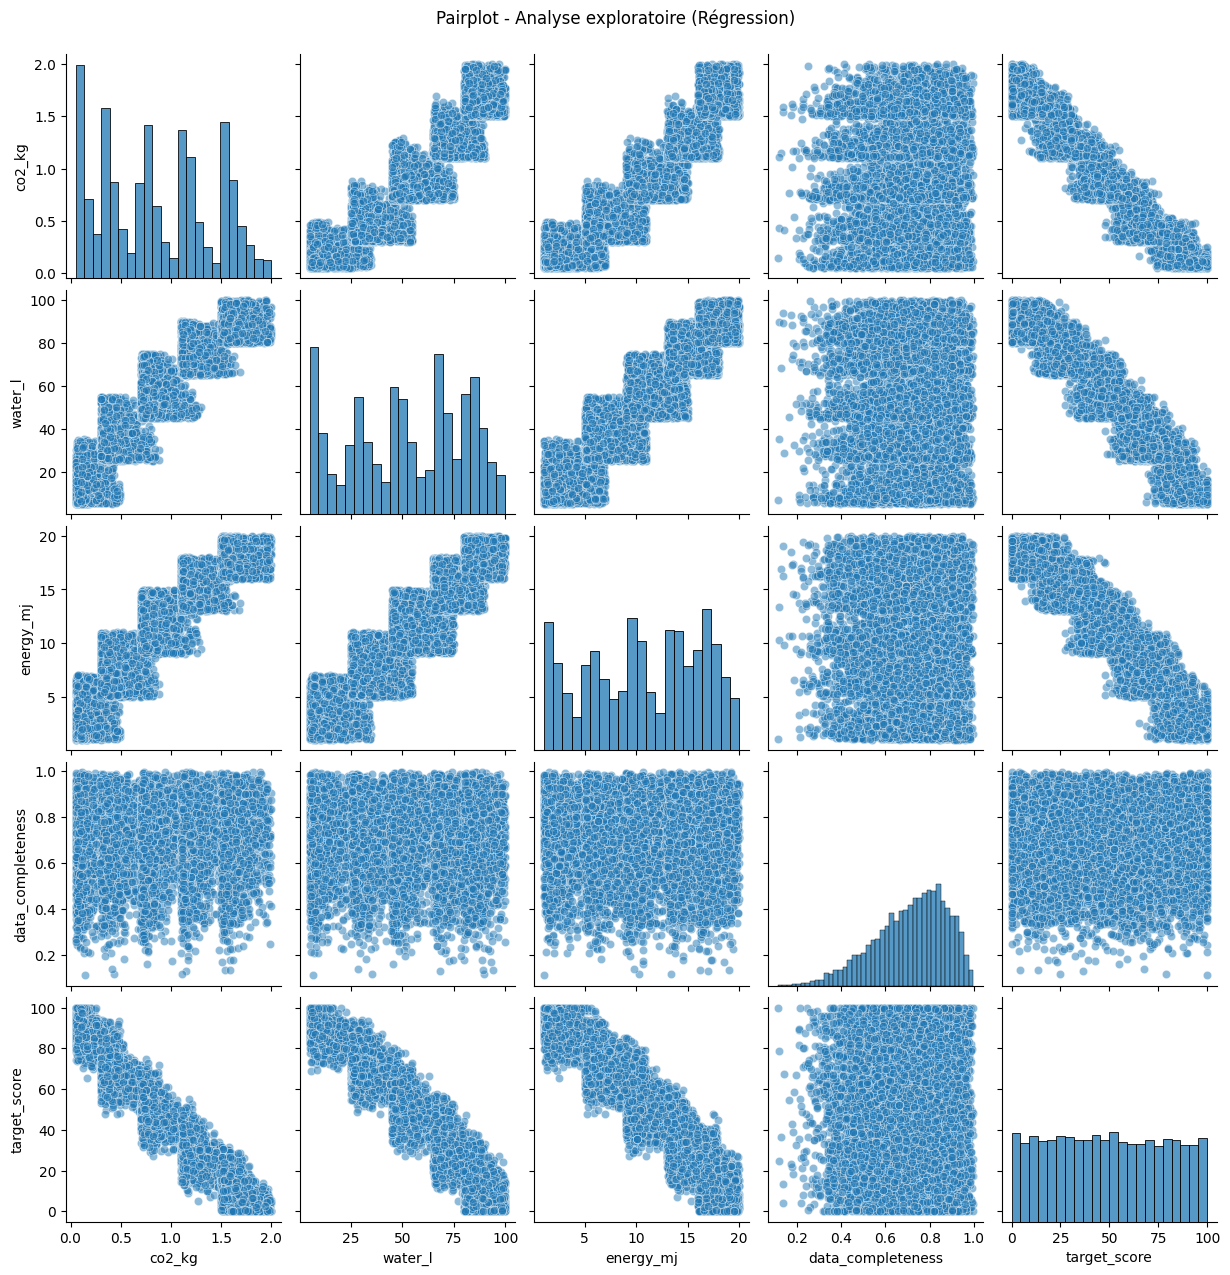

In [44]:
# Sélection de quelques variables pour le pairplot
cols_features = ['co2_kg', 'water_l', 'energy_mj', 'data_completeness', 'target_score']
sns.pairplot(df[cols_features], corner=False, diag_kind='hist', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot - Analyse exploratoire (Régression)", y=1.02)
plt.show()


## 3. Préparation des Features


In [45]:
# Préparer les features
loader = DatasetLoader()
X, y = loader.prepare_features(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Features: {list(X.columns)}")
print(f"Train: {len(X_train)} échantillons")
print(f"Test: {len(X_test)} échantillons")
print(f"\nStatistiques target:\n  Moyenne: {y.mean():.2f}\n  Écart-type: {y.std():.2f}")


Features: ['co2_kg', 'water_l', 'energy_mj', 'packaging_plastic', 'packaging_glass', 'packaging_paper', 'packaging_other', 'data_completeness', 'ingredient_count', 'transport_distance_km']
Train: 8000 échantillons
Test: 2000 échantillons

Statistiques target:
  Moyenne: 49.43
  Écart-type: 28.98


## 4. Entraînement des Modèles

## Linear Regression

In [46]:
# Linear Regression
print("Linear Regression...")
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_pred = linear_model.predict(X_test)

linear_rmse = np.sqrt(mean_squared_error(y_test, linear_pred))
linear_r2 = r2_score(y_test, linear_pred)

print(f"RMSE: {linear_rmse:.2f}, R²: {linear_r2:.3f}\n")

Linear Regression...
RMSE: 5.18, R²: 0.969



## Polynomial Regression

In [47]:
# Polynomial Regression
scaler_poly = StandardScaler()
X_train_scaled_poly = scaler_poly.fit_transform(X_train)
X_test_scaled_poly = scaler_poly.transform(X_test)

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_scaled_poly)
X_test_poly = poly_features.transform(X_test_scaled_poly)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_pred = poly_model.predict(X_test_poly)
poly_rmse = np.sqrt(mean_squared_error(y_test, poly_pred))
poly_r2 = r2_score(y_test, poly_pred)
print(f"Polynomial Regression: RMSE={poly_rmse:.2f}, R²={poly_r2:.3f}")


Polynomial Regression: RMSE=5.18, R²=0.968


## Random Forest


In [48]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest: RMSE={rf_rmse:.2f}, R²={rf_r2:.3f}")


Random Forest: RMSE=5.30, R²=0.967


## XGBoost

In [49]:
# XGBoost
print("XGBoost...")
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.3f}\n")


XGBoost...
RMSE: 5.29, R²: 0.967



## 5. Comparaison et Visualisation

### Comparaison des Métriques


               Modèle     RMSE       R²      MAE
    Linear Regression 5.175602 0.968533 4.130356
Polynomial Regression 5.178554 0.968497 4.131770
              XGBoost 5.286060 0.967176 4.214777
        Random Forest 5.296654 0.967044 4.214637

Meilleur modèle: Linear Regression (R²: 0.9685)


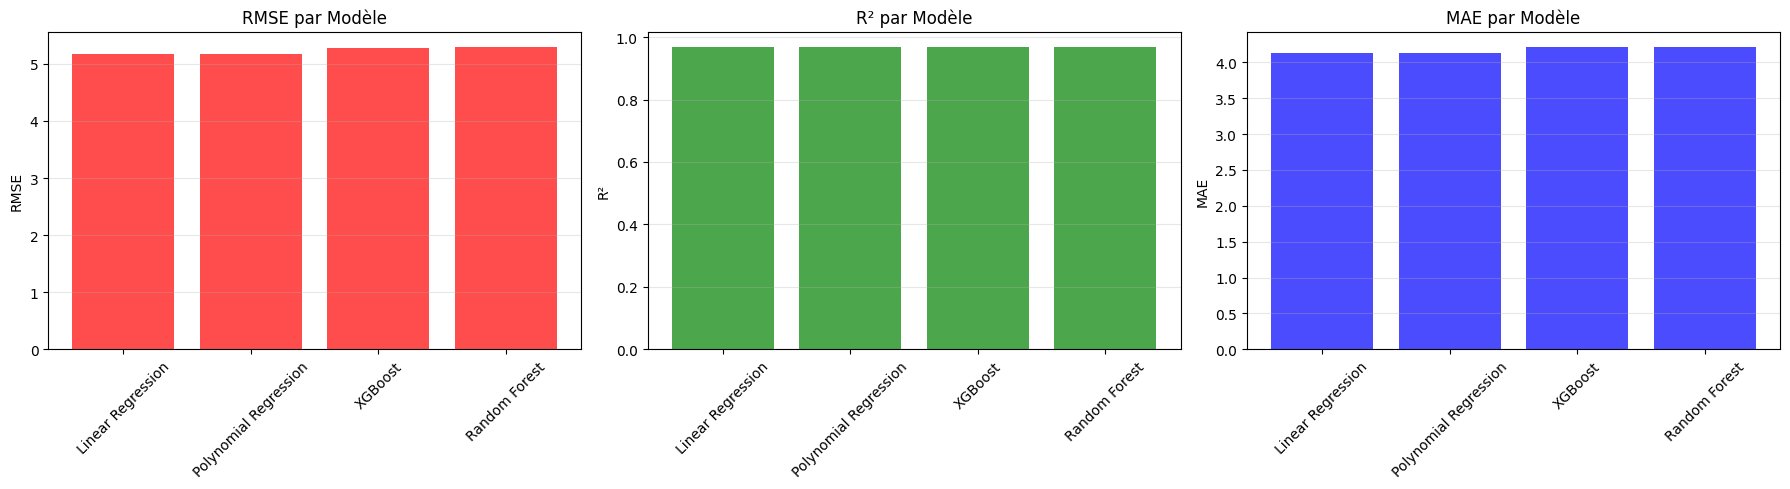


📈 Statistiques des Résidus (Linear Regression):
  Moyenne: 0.0356
  Écart-type: 5.1768
  Min: -18.7663
  Max: 19.1952


In [50]:
# Calculer aussi MAE pour chaque modèle
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
linear_mae = mean_absolute_error(y_test, linear_pred)
poly_mae = mean_absolute_error(y_test, poly_pred)

# Créer un DataFrame de comparaison
comparison = pd.DataFrame({
    'Modèle': ['Linear Regression', 'Polynomial Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [linear_rmse, poly_rmse, rf_rmse, xgb_rmse],
    'R²': [linear_r2, poly_r2, rf_r2, xgb_r2],
    'MAE': [linear_mae, poly_mae, rf_mae, xgb_mae]
}).sort_values('R²', ascending=False)

# Affichage de la comparaison
print(comparison.to_string(index=False))
print(f"\nMeilleur modèle: {comparison.iloc[0]['Modèle']} (R²: {comparison.iloc[0]['R²']:.4f})")

# Visualisation des métriques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axes[0].bar(comparison['Modèle'], comparison['RMSE'], color='red', alpha=0.7)
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE par Modèle')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# R²
axes[1].bar(comparison['Modèle'], comparison['R²'], color='green', alpha=0.7)
axes[1].set_ylabel('R²')
axes[1].set_title('R² par Modèle')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

# MAE
axes[2].bar(comparison['Modèle'], comparison['MAE'], color='blue', alpha=0.7)
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE par Modèle')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Identifier le meilleur modèle
best_model_name = comparison.iloc[0]['Modèle']

if best_model_name == 'Random Forest':
    best_pred = rf_pred
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_pred = xgb_pred
    best_model = xgb_model
elif best_model_name == 'Linear Regression':
    best_pred = linear_pred
    best_model = linear_model
    best_pred = linear_pred
    best_model = linear_model
else:  # Polynomial Regression
    best_pred = poly_pred
    best_model = poly_model

# Statistiques des résidus
residuals = y_test - best_pred
print(f"\n📈 Statistiques des Résidus ({best_model_name}):")
print(f"  Moyenne: {residuals.mean():.4f}")
print(f"  Écart-type: {residuals.std():.4f}")
print(f"  Min: {residuals.min():.4f}")
print(f"  Max: {residuals.max():.4f}")


## 6. Sauvegarde des Modèles


In [51]:
# Create folder
saved_models_dir = Path("../saved_models")
saved_models_dir.mkdir(exist_ok=True)

# Best model name (from your comparison table)
best_model_name_save = comparison.iloc[0]['Modèle']
print(f"\nMEILLEUR MODÈLE: {best_model_name_save}")
print(f"   R²: {comparison.iloc[0]['R²']:.4f}, RMSE: {comparison.iloc[0]['RMSE']:.4f}\n")

# Helper: safely get objects if they exist
def get_if_defined(var_name):
    return globals().get(var_name, None)

# Retrieve optional transformers safely
scaler_linear = get_if_defined("scaler_linear")  # may be None
scaler_poly   = get_if_defined("scaler_poly")    # should exist if you scaled poly
poly_features = get_if_defined("poly_features")  # IMPORTANT for polynomial inference

# Save all models + their preprocessors
models_to_save = [
    # model, name, dict of extra objects to save, metrics
    (linear_model, 'linear_regression',
     {'scaler': scaler_linear},  # usually None
     {'rmse': linear_rmse, 'r2': linear_r2, 'mae': linear_mae}),

    (poly_model, 'polynomial_regression',
     {'scaler': scaler_poly, 'poly_features': poly_features},
     {'rmse': poly_rmse, 'r2': poly_r2, 'mae': poly_mae}),

    (rf_model, 'random_forest',
     {},
     {'rmse': rf_rmse, 'r2': rf_r2, 'mae': rf_mae}),

    (xgb_model, 'xgboost',
     {},
     {'rmse': xgb_rmse, 'r2': xgb_r2, 'mae': xgb_mae})
]

for model, name, extras, metrics in models_to_save:
    # Save model
    with open(saved_models_dir / f"{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)

    # Save extra preprocessors if present
    for extra_name, extra_obj in extras.items():
        if extra_obj is not None:
            with open(saved_models_dir / f"{name}_{extra_name}.pkl", "wb") as f:
                pickle.dump(extra_obj, f)

    # Save metadata
    metadata = {
        "model_name": name,
        "feature_names": list(X.columns),
        "metrics": metrics,
        "extras_saved": [k for k, v in extras.items() if v is not None]
    }
    with open(saved_models_dir / f"{name}_metadata.json", "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"{name} sauvegardé")

# --- Save the best model as best_model.pkl (+ its preprocessors)
model_name_map = {
    'Random Forest': ('random_forest', rf_model, {}),
    'XGBoost': ('xgboost', xgb_model, {}),
    'Linear Regression': ('linear_regression', linear_model, {'scaler': scaler_linear}),
    'Polynomial Regression': ('polynomial_regression', poly_model, {'scaler': scaler_poly, 'poly_features': poly_features})
}

best_name, best_model_obj, best_extras = model_name_map[best_model_name_save]
best_metrics_save = comparison[comparison['Modèle'] == best_model_name_save].iloc[0]

print(f"\n{'='*70}")
print(f"SAUVEGARDE DU MEILLEUR MODÈLE: {best_model_name_save}")
print(f"{'='*70}")

with open(saved_models_dir / "best_model.pkl", "wb") as f:
    pickle.dump(best_model_obj, f)

for extra_name, extra_obj in best_extras.items():
    if extra_obj is not None:
        with open(saved_models_dir / f"best_model_{extra_name}.pkl", "wb") as f:
            pickle.dump(extra_obj, f)

best_metadata = {
    "model_name": best_name,
    "display_name": best_model_name_save,
    "feature_names": list(X.columns),
    "metrics": {
        "rmse": float(best_metrics_save["RMSE"]),
        "r2": float(best_metrics_save["R²"]),
        "mae": float(best_metrics_save["MAE"])
    },
    "rank": 1,
    "selection_criteria": "Highest R² score",
    "extras_saved": [k for k, v in best_extras.items() if v is not None]
}

with open(saved_models_dir / "best_model_metadata.json", "w") as f:
    json.dump(best_metadata, f, indent=2)

print(f"Meilleur modèle sauvegardé: {best_model_name_save}")
print(f"   R²: {best_metadata['metrics']['r2']:.4f}, RMSE: {best_metadata['metrics']['rmse']:.4f}, MAE: {best_metadata['metrics']['mae']:.4f}")
print(f"   Fichier: best_model.pkl")
print(f"\nTous les modèles sont sauvegardés!")



MEILLEUR MODÈLE: Linear Regression
   R²: 0.9685, RMSE: 5.1756

linear_regression sauvegardé
polynomial_regression sauvegardé
random_forest sauvegardé
xgboost sauvegardé

SAUVEGARDE DU MEILLEUR MODÈLE: Linear Regression
Meilleur modèle sauvegardé: Linear Regression
   R²: 0.9685, RMSE: 5.1756, MAE: 4.1304
   Fichier: best_model.pkl

Tous les modèles sont sauvegardés!
